# **SC3000 / CZ3005 Artifical Intelligence Assignment 1**
Applying Deep Q Learning to solve the CartPole problem

<br>

## **Authors**

| Name           | Matriculation Number | Contribution |
|----------------|----------------------|--------------|
| Agarwal Anusha | U2023105H | Reinforcement Learning Code |
| Chee Wen Zhan  | U2122475L | Documentation and Hyperparameters Tuning |

<br>

## **References**
https://github.com/yue-zhongqi/cartpole_colab <br>
https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html <br>
https://pytorch.org/docs/stable/index.html <br>
https://www.gymlibrary.dev/environments/classic_control/cart_pole/

<br>

## **AI Usage**
ChatGPT: Code generation and understanding documentation

## Task 0: Setting up the Cart-Pole RL Model

### 0.1 Installing Dependencies:

In [1]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1


### 0.2 Importing Dependencies:

In [2]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay


import torch
import torch.nn as nn
# used to define and train the neural network that approximates the Q-value function.
import torch.optim as optim
# provides functional operations, including the ReLU activation function
import torch.nn.functional as F
from collections import namedtuple, deque
from itertools import count


### 0.3 Define Helper Function:

In [3]:
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="Cart-Pole Env" autoplay
                loop controls style="height: 450px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 0.4 Set up Matplotlib and Load CartPole Env -

In [4]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

# turns on interactive mode for Matplotlib.
plt.ion()

device = torch.device("cpu")

#Load the CartPole Env -
env = gym.make("CartPole-v1")

## Task 1: Development of Cart-Pole RL Agent

### 1.1 Motivations for using DQN Model -

1. DQN is a ***model-free reinforcement learning algorithm***, which means it does not require prior knowledge of the environment dynamics. This makes it easy to apply to the CartPole environment.

2. DQN uses an ***epsilon-greedy exploration strategy, which balances exploration and exploitation*** by selecting a random action with probability epsilon and the action with the highest Q-value with probability 1-epsilon. This helps the agent to discover new actions and avoid getting stuck in policies that aren't globally optimal - It helps create some randomness.

3. DQN uses ***experience replay***, which allows the agent to learn from past experiences by storing transitions in a replay buffer and randomly sampling from it during training. This reduces the correlation between consecutive updates and improves the stability of the learning process.

### 1.2 Define Parameters, Hyperparameters, and Methods to render the DQN Model -

For the DQN Model, we're using the Epsilon-greedy policy - balancing exploration and exploitation. For every action taken, there are two possibilities:
    #1) Choose a random action to explore the state map with probability P = EPSILON
    #2) Choose the best action based on exploiting Q values with probability P = 1 - EPSILON

This policy would benefit us because it balances exploiting best-known action and exploring new actions using randomness to avoid getting stuck in local optima

#### 1.2.1 Define Epsilon:

Since Epsilon Greedy policy balances between exploration and exploitation, hence we define a range - where the model gradually shifts from exploration (high EPSILON) during the initial phase to exploitation (low EPSILON) when it gains experience over EPSILON_DECAY_LENGTH steps (linearly).

In [5]:
# Epsilon value renges between [MIN_EPSILON,EPSILON]
EPSILON = 0.9
MIN_EPSILON = 0.05
#Epsilon decays linearly over EPSILON_DECAY_LENGTH steps
EPSILON_DECAY_LENGTH = 5000

### 1.2.2 Define State Transition tuple:

``Transition`` - is a named tuple with four fields:
- ``current_state`` - the current state of cart-pole
- ``action`` - action to take from current state to next state
- ``next_state`` - next state of cart-pole after taking the chosen action
- ``reward`` - utility/reward on taking the chosen action and entering the next state

It is used to represent a single transition in the RL environment, where an agent takes an action in a given state, transitions to a new state, and receives a reward.

In [6]:
Transition = namedtuple("transition", ("current_state", "action", "next_state", "reward"))

### 1.2.3 Define ReplayMemory class:

ReplayMemory class stores a series of recently observed transitions. It helps model use paste experience to improve agent's policy and thereby improve agent's decision making.

Replay memory uses sample function to choose a random transition set to achieve the following -
1. Break the correlation between consecutive transitions (agent's past experience) which make the learning process unstable
2. Increase stability by being less exposed to extreme events.

This allows the agent to learn from a diverse set of experiences and reduces the likelihood of overfitting to any specific experience.

In [7]:
#set maximum length of ReplayMemory
MAX_BUFFER_SIZE = 10000

#set sample size for ReplayMemory
BATCH_SIZE = 128
#set discount factor in ReplayMemory
DISCOUNT_FACTOR = 0.99

class ReplayMemory(object):
    def __init__(self):
      # store replay memory as a doubly ended queue to allow for easy add and removal of elements
      self.memory = deque([], maxlen=MAX_BUFFER_SIZE)

    # replay memory is a dequeue storing transition sets of past experience
    # *args indicates that the function can take arbitrary number of arguments
    # these arguments are packed as a Transition tuple and appended to the memory queue
    def store_transition(self, *args):
      self.memory.append(Transition(*args))

    # function to return a random subset of the Transitions (past experience) stored in memory
    # this function allows to choose random transition to
        #a) Removes the high correlation that sequential observations have
        #b) Increases stability by being less exposed to extreme events
    def sample(self):
      return random.sample(self.memory, BATCH_SIZE)

    #overrides inbuilt len function to length of memory
    def __len__(self):
      return len(self.memory)

### 1.2.4 Define the DQN class:

We create a neural network of 4 linear layers.

- nn.Linear(in_features, out_features):
  follows equation y = xA^T + b, where x is the input, A is the weight, b is the bias, and y is the output.
  Random initialization a weight matrix and a bias vector. The size of the weight matrix is out_features x in_features, and the size of the bias vector is out_features.

- nn.ReLU(input_tensor):
  follows equation f(x)=max(0,x), where x is the input. It sets all negative values in the tensor to 0 and leaves the positive values unchanged.

In [8]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()

        # layer 1 accepts n_observations input features and 128 output features. This is connected to Layer 2 ... Layer 3 ... Layer 4
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, 128)
        self.layer4 = nn.Linear(128, n_actions)

    def forward(self, x):
        #each neuron first does dot product of its weight with input vector, before going through RecLU after which it is passed to next neuron
        #ReLU: for every axis i in the final vector, i = max(0, i)
        #Eg. relu([1,2,-4]) = [1,2,0]
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        return self.layer4(x)


### 1.2.5 Define Policy NN and Target NN:

In [9]:
# TAU determines the update rate of the Target NN.
TAU = 0.005

# learning rate for policy NN
# low LR means policy NN weight uppdates are slow
LR = 1E-4

# there are 2 possible actions - push left or push right (0 or 1)
n_actions = 2
# there are 4 variables to observe - cart position, velocity and pole angle, angular velocity
n_observations = 4

#### 1.2.5.1 Policy Neural Network (Policy NN):

The policy network estimates Q value for each state action pair for the given state $Q(s, a_t)$, where $a_t$∈A.
We want to minimize the Temoporal Difference (TD) loss. Therefore, during training. policy network will be updated to minimize the difference between estimated Q value and target Bellman Q value which is the TD loss

In [10]:
policy_NN = DQN(n_observations, n_actions).to(device)

#### 1.2.5.2 Target Neural Network (Policy NN):

The target network is initialized with the same weights as policy_network by loading its state dictionary. This is done to ensure that the target_network starts with the same initial weights as the policy_network and its weights are updated later during the training process.

It estimates future rewards more slowly than the policy network to add stability and make the learning process more reliable.
This is accomplished with the help of $\tau$

In [11]:
target_NN = DQN(n_observations, n_actions).to(device)
#set the weights of the target model to the weights from the policy model.
target_NN.load_state_dict(policy_NN.state_dict())

<All keys matched successfully>

#### 1.2.5.2 Define Adam Optimizer:

AdamW is a variant of the Adam optimizer that includes weight decay to prevent overfitting. Sets the parameters to be optimized to the parameters of the policy network

In [12]:
# define AdamW optimizer to optimize the parameters of the policy NN.
optimizer = optim.AdamW(policy_NN.parameters(), lr=LR,amsgrad = True)
# call the memory buffer with past experience transition sets
memory = ReplayMemory()

### 1.2.6 Define ``select_action()`` function:

This function is used to select an optimal action to maximize the reward. It implements an epsilon-greedy policy for selecting actions given the current state.

In [13]:
# The cumulated reward of an episode
step_counter = 0

# If model is training, set training to True. If model is used for testing, set to False instead
def select_action(observation, training = True):
    global step_counter
    # linearly decaying EPSILON


    eps_threshold =  EPSILON - (EPSILON-MIN_EPSILON) * min(step_counter, EPSILON_DECAY_LENGTH)/EPSILON_DECAY_LENGTH
    # eps_threshold = MIN_EPSILON + (EPSILON - MIN_EPSILON) * \
    #     math.exp(-1. * step_counter / EPSILON_DECAY_LENGTH)




    # model adds a reward of 1 every time it executes the state_action funcion
    step_counter += 1

    if training == False or random.random() > eps_threshold:
      # Using torch.no_grad ensures that the gradients are not computed during the forward pass to waste memory
      with torch.no_grad():
          # policy_NN (observation) returns tensor of shape (1,2). It would be something like [a,b]
          # here, a - estimated q value for doing action 0
          # here, b - estimated q value for doing action 1
          # policy_NN(observation).max(1) gives a tuple of two tensors (x, y).
          # here, x : max(Q(S,0), Q(S,1)) tensor containing max of each row
          # here, y : argmax i.e. the corresponding index for each row
          # policy_NN(observation).max(1)[1] returns the argmax
          # policy_NN(observation).max(1)[1].view(1,1) reshapes the argmax to a (1,1) tensor

          # Therefore, we pick the action with the larges expected reward
            return policy_NN(observation).max(1)[1].view(1,1)
    else:

      # Explore by randomly selecting an action from the action space
      # env.action_space.sample() returns a random action from the action space
      # the returned tensor has shape (1, 1)
      return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 1.2.7 Define ``optimize_model()`` function:

The function takes a random batch of transitions (i.e., current_state, action, next_state, reward) tuples from the replay memory  and uses it to update the policy network by minimizing the temporal-difference (TD) error between the expected and actual Q-values

In [14]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
      #replay memory doesn't have enough samples for a batch, exit the function
      return
    # sample a batch of transitions from memory
    transitions = memory.sample()

    # initially "transitions" is a set of transitions with ("current_state","action","next_state","reward")
    # create a new Transition tuple named "batch"
    # batch.current_state= [all current states], batch.action = [all action], batch.next_state = [all next states], batch.reward = [all reward]
    batch = Transition(*zip(*transitions))

    # boolean tensor that is used to filter out the final states/None state in the batch.
    # map the lambda function to all the next_states in batch and convert it into a tuple
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)

    #concatenates all non-empty next_states in batch
    # print([s for s in batch.next_state if s is not None])
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.current_state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # policy_NN(state_batch) runs policy network against every element in state_batch to get [ [Q(S, 0)],[Q(S, 1)]  ]
    # gather(1,action_batch) iterates over the columns (first dimension) to get the corresponding indices
    # if the corresponding action_batch was 0 you'd take [Q(S,0)], otherwise you'd take [Q(S,1)]
    state_action_values = policy_NN(state_batch).gather(1, action_batch)

    # create a 1-D vector initialized to all 0, of length BATCH_SIZE.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)

    # dont do gradient calculation to be more efficient, save memory
    with torch.no_grad():
      # target network takes the non final next states, to get Q value estimates,and choose the optimal action, with highest reward
      # [0] corresponds to the Q values
      # update the corresponding next state values
      next_state_values[non_final_mask] = target_NN(non_final_next_states).max(1)[0]

    # calculate the expected Q values using Bellman equation
    expected_state_action_values = (next_state_values * DISCOUNT_FACTOR) + reward_batch

    # # computer mean square error loss
    # criterion = nn.MSELoss()
    # loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))



    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    #optimize the model

    # set the gradients of all the parameters in the optimizer to zero to not let previous iteration gradient effect us
    optimizer.zero_grad()
    # compute the gradients of the loss with respect to all the parameters of the neural network.
    # backpropogation to change update the weights
    loss.backward()

    # set max gradient of parameters to be 100.
    # this prevents gradients from growing too large during training and causing weights to explode
    torch.nn.utils.clip_grad_value_(policy_NN.parameters(), 100)
    # update the parameters of the NN based on the gradients computed during backpropagation
    optimizer.step()


### 1.2.8 Define ``plot_duration()`` function:

In [15]:
# duration for episodes
episode_durations = []

def plot_durations(show_result=False):
    plt.figure(1)

    # create a tensor from the list of episode durations
    durations_t = torch.tensor(episode_durations, dtype=torch.float)

    # create a plot titled "Result" once all episodes have ended, otherwise show the training phase
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')

    x = list(range(0, len(episode_durations)))
    # plot the required mean of 195 needed for trained model
    y = [195]*len(x)
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy(), color='r', label="Duration per Episode")
    plt.plot(x,y, color='y', label="Y=195")

    # take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy(), color='b', label="Mean of 100")
    plt.legend()

    # pause for a short time so that the plot can be updated.
    plt.pause(0.001)

    # display the plot figure
    if is_ipython:
        if not show_result:
          # plt.gcf() stands for "Get Current Figure" in Matplotlib
          display.display(plt.gcf())
          display.clear_output(wait=True)
        else:
          display.display(plt.gcf())

## 1.2 Training DQN Model

Train the model for 5000 episodes

Complete
[18, 21, 20, 13, 19, 21, 14, 27, 19, 11, 13, 31, 21, 16, 14, 41, 21, 12, 12, 15, 9, 16, 13, 14, 35, 25, 25, 12, 16, 18, 30, 19, 37, 15, 20, 12, 22, 72, 38, 14, 15, 25, 19, 17, 13, 15, 15, 18, 23, 37, 15, 24, 28, 21, 21, 20, 42, 38, 58, 95, 142, 184, 79, 56, 82, 42, 81, 67, 140, 205, 185, 84, 192, 219, 126, 148, 366, 291, 278, 248, 315, 274, 283, 224, 227, 245, 382, 254, 254, 245, 236, 319, 178, 286, 251, 282, 285, 243, 253, 294, 500, 320, 129, 124, 129, 150, 116, 117, 113, 113, 108, 99, 110, 103, 111, 110, 108, 103, 108, 122, 112, 119, 214, 207, 120, 117, 120, 214, 14, 216, 14, 47, 49, 226, 53, 54, 51, 179, 177, 51, 49, 50, 39, 500, 288, 288, 273, 268, 247, 247, 244, 233, 239, 247, 238, 232, 219, 225, 223, 211, 219, 232, 219, 225, 208, 219, 222, 229, 236, 250, 249, 247, 263, 264, 271, 272, 277, 303, 375, 353, 407, 500, 500, 400, 500, 485, 348, 397, 500, 500, 500, 369, 349, 336, 339, 315, 291, 271, 279, 296, 298, 304, 314, 292, 311, 348, 341, 357, 348, 390, 394, 423, 445, 500, 

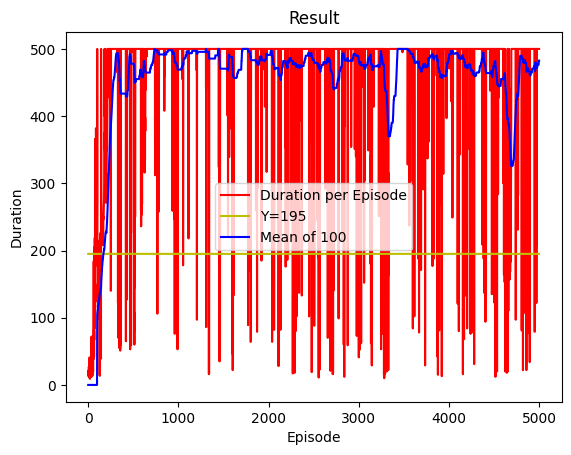

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [16]:
num_episodes = 5000

for i_episode in range(num_episodes):
    # get initial state
    curr= env.reset()

    #convert it to a tensor
    curr = torch.tensor(curr, dtype=torch.float32, device=device).unsqueeze(0)

    for t in count():
      action = select_action(curr)
      next_obs, reward, done, info = env.step(action.item())
      reward = torch.tensor([reward], device=device)
      done = done or info

      #terminal states cannot continue on
      if done:
          next_obs = None
      else:
          next_obs = torch.tensor(next_obs, dtype=torch.float32, device=device).unsqueeze(0)

      # Store the transition set in memory
      memory.store_transition(curr, action, next_obs, reward)

      # move current to the next state
      curr = next_obs

      # perform one step of the optimization on the policy network
      optimize_model()

      # soft update of the target network's weights

      # θ′ ← τ θ + (1 −τ )θ′

      # θ are the weights of the policy network,
      # θ′ are the weights of the target network, and
      # τ is a hyperparameter (set to 0.001).
      target_NN_state_dict = target_NN.state_dict()
      policy_NN_state_dict = policy_NN.state_dict()
      for key in policy_NN_state_dict:
          target_NN_state_dict[key] = policy_NN_state_dict[key]*TAU + target_NN_state_dict[key]*(1-TAU)
      target_NN.load_state_dict(target_NN_state_dict)

      if done:
          episode_durations.append(t + 1)

          plot_durations()
          break

print('Complete')
print(episode_durations)
#Plot the rewards of the training phase
plot_durations(show_result=True)
plt.ioff()
plt.show()

### 1.2.1 Save the trained Policy and Target network into torch

In [17]:
print(episode_durations)

[18, 21, 20, 13, 19, 21, 14, 27, 19, 11, 13, 31, 21, 16, 14, 41, 21, 12, 12, 15, 9, 16, 13, 14, 35, 25, 25, 12, 16, 18, 30, 19, 37, 15, 20, 12, 22, 72, 38, 14, 15, 25, 19, 17, 13, 15, 15, 18, 23, 37, 15, 24, 28, 21, 21, 20, 42, 38, 58, 95, 142, 184, 79, 56, 82, 42, 81, 67, 140, 205, 185, 84, 192, 219, 126, 148, 366, 291, 278, 248, 315, 274, 283, 224, 227, 245, 382, 254, 254, 245, 236, 319, 178, 286, 251, 282, 285, 243, 253, 294, 500, 320, 129, 124, 129, 150, 116, 117, 113, 113, 108, 99, 110, 103, 111, 110, 108, 103, 108, 122, 112, 119, 214, 207, 120, 117, 120, 214, 14, 216, 14, 47, 49, 226, 53, 54, 51, 179, 177, 51, 49, 50, 39, 500, 288, 288, 273, 268, 247, 247, 244, 233, 239, 247, 238, 232, 219, 225, 223, 211, 219, 232, 219, 225, 208, 219, 222, 229, 236, 250, 249, 247, 263, 264, 271, 272, 277, 303, 375, 353, 407, 500, 500, 400, 500, 485, 348, 397, 500, 500, 500, 369, 349, 336, 339, 315, 291, 271, 279, 296, 298, 304, 314, 292, 311, 348, 341, 357, 348, 390, 394, 423, 445, 500, 500, 500,

In [19]:
# save_path = "content/"

torch.save(target_NN.state_dict(), "targetNN.pt")
torch.save(policy_NN.state_dict(), "policyNN.pt")

# Download the model to your device
from google.colab import files
files.download("targetNN.pt")
files.download("policyNN.pt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 1.2.2 Example of Obs and Chosen Action

In [20]:
observation = env.reset()
# convert it to tensor
observation = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

# select the optimum action
action = select_action(observation)
print("Observation:", observation.numpy()[0])
print("Chosen action:", action.item())

Observation: [-0.00488226  0.04122921  0.03861592  0.04645974]
Chosen action: 1


##**Task 2: Demonstrate the Effectiveness of the RL agent**

For this task, the agent developed in Task 1 plays the game for 100 episodes. We record the cumulative reward for each round, and plot the reward for each round.

### 2.1 Initialize the paramters:

In [21]:
# define number of episodes
num_episodes = 100

# create an empty array to store the cumulative rewards of 100 episodes
results = np.zeros(100)

rr = np.zeros(100)

### 2.2 Iterate through 100 episodes

For each episode following steps are followed -
1. Reset the cart-pole environment
2. Calculate the cumulative reward
3. Store the transition in memory
4. Save reward of each episode to results array

In [22]:
from inspect import currentframe
for i_episode in range(0, num_episodes):

    # 1. Reset the environment
    curr = env.reset()

    # convert it to a tensor
    curr = torch.tensor(curr, dtype=torch.float32, device=device).unsqueeze(0)

    episode_reward=0
    for t in count():
        action = select_action(curr, False)
        next_obs, reward, done, info = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = done or info

        # if terminal state, just put next observation as None
        if done:
            next_obs = None
        else:
            next_obs = torch.tensor(next_obs, dtype=torch.float32, device=device).unsqueeze(0)

        episode_reward+=reward

        # 3. Store the transition in memory
        memory.store_transition(curr, action, next_obs, reward)

        # move current state to to the next state
        curr = next_obs

        # 4. Save rewards to results array
        if done:
          rr[i_episode]=episode_reward
          results[i_episode] = t
          break

print(rr)

[500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500.
 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500.
 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500.
 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500.
 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500.
 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500.
 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500.
 500. 500.]


### 2.3 Plot the results

Minimum required mean for successful run is 195. Therefore, we keep 195 as the reference line to evaluate the performance of our model. We generate the graph for 100 episodes to compare our cumulative reward mean to the threshole mean of 195

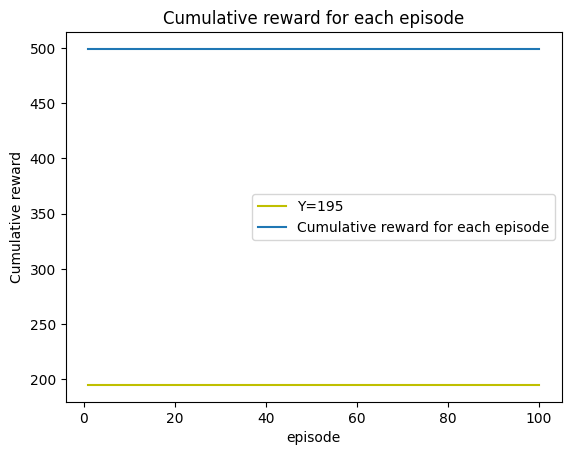

In [23]:
# draw a line y = 195
# compare agaisnt required mean of 195, needed for the trained model
x = [i for i in range(1,101)]
y = [195]*len(x)
plt.plot(x,y, color='y', label="Y=195")

# plot line showing rewards for each episode
plt.plot(x, results, label="Cumulative reward for each episode")

plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.legend()

# display the final graph
plt.show()

### 2.4 Compare Model Cumulative Reward vs Threshold Mean (195)

In [24]:
print("Average cumulative reward:", results.mean())
print("Is my agent good enough?", results.mean() > 195)

Average cumulative reward: 499.0
Is my agent good enough? True


We consistently manage to achieve an avg cumulative reward of 500 (max possible) which indicates that our model is good enough and indeed performs very well - can remain stable for a long amt of time!

## ***Task 3: Render one episode played by the agent***

### 3.1 Initialize the paramteres

In [25]:
# define the cart pole environment
env = RecordVideo(gym.make("CartPole-v1"), "./video")

# reset environment before running the episode
observation = env.reset()

# rendering process
while True:
    env.render()
    #your agent goes here
    observation = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0) #convert it to a tensor
    action = select_action(observation, False)
    observation, reward, done, info = env.step(action.item())
    if done:
      break;
env.close()

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


### 3.2 Play the video

In [26]:
show_video()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
